In [9]:
from pathlib import Path
from tqdm import tqdm
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from netCDF4 import Dataset
import shapely
from shapely.geometry import Point, box
import matplotlib.pyplot as plt

target_crs = "ESRI:102004"

save_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/data/distributed/")
metadata_dir = save_dir / "metadata" 
metadata_dir.mkdir(exist_ok=True)


print("reading hydrobasins")
hybas_dir = Path("/nas/cee-water/cjgleason/data/HydroSHEDS/HydroBASINS")
shp_file = hybas_dir / "hybas_na_lev01-12_v1c" / "hybas_na_lev09_v1c.shp"
hybas = gpd.read_file(shp_file, engine="pyogrio", use_arrow=True)
hybas = hybas.set_index('HYBAS_ID')
hybas = hybas.to_crs(target_crs)

hybas = hybas[hybas['ENDO']==0] # Remove endorheic basins

print("Done!")

reading hydrobasins
Done!


1962


<Axes: >

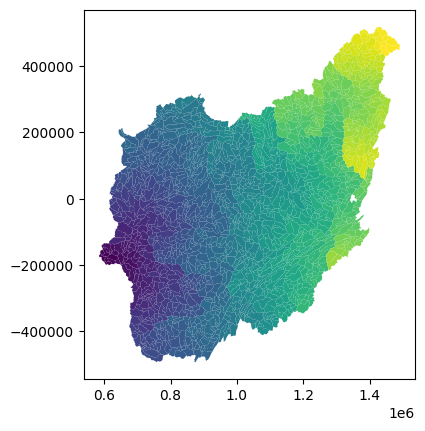

In [10]:
# outlet_idx = 7090574260 # Portsmouth, downstream of Scioto

outlet_idx = 7090612640
basin_name = 'Ohio'

# outlet_idx = 7090569640 
# basin_name = 'Missouri'

# outlet_idx = 7090569550
# basin_name = 'Upper_Miss'

outlet = hybas.loc[[outlet_idx]]
basin = outlet.copy()

next_up = hybas[hybas["NEXT_DOWN"] == outlet_idx]
while not next_up.empty:
    basin = pd.concat([basin, next_up], ignore_index=False)
    #find the new next_up
    next_up = hybas[hybas["NEXT_DOWN"].isin(next_up.index)]

basin = basin.reset_index()
print(len(basin))
basin.plot('DIST_MAIN')

In [11]:
import networkx as nx

# Build basic watershed graph
"""Build directed graph from watershed data"""
G = nx.DiGraph()

# Add all nodes with their attributes
for idx, row in basin.iterrows():
    G.add_node(row['HYBAS_ID'], 
              dist_main=row['DIST_MAIN'],
              original_index=idx)

# Add direct downstream connections
print("Building watershed connectivity...")
edges_added = 0
for idx, row in tqdm(basin.iterrows(), total=len(basin)):
    current_id = row['HYBAS_ID']
    next_down_id = row['NEXT_DOWN']
    
    # Skip outlets
    if pd.isna(next_down_id) or next_down_id == 0:
        continue
        
    # Add edge if downstream node exists
    if next_down_id in G.nodes:
        distance = row['DIST_MAIN'] - G.nodes[next_down_id]['dist_main']
        G.add_edge(current_id, next_down_id, distance=distance)
        edges_added += 1

print(f"Added {edges_added} direct connections")


Building watershed connectivity...


100%|██████████| 1962/1962 [00:00<00:00, 24802.28it/s]

Added 1961 direct connections


In [12]:
# Analyze basic graph structure
def analyze_graph(G):
    """Quick graph analysis"""
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")
    print(f"Connected components: {nx.number_weakly_connected_components(G)}")
    print(f"Density: {nx.density(G):.4f}")
    
    # Find sources and sinks
    sources = [n for n in G.nodes() if G.in_degree(n) == 0]
    sinks = [n for n in G.nodes() if G.out_degree(n) == 0]
    print(f"Sources (headwaters): {len(sources)}")
    print(f"Sinks (outlets): {len(sinks)}")
    
    # Distance stats
    distances = [data['distance'] for _, _, data in G.edges(data=True)]
    if distances:
        print(f"Distance range: {min(distances):.2f} - {max(distances):.2f}")
        print(f"Mean distance: {np.mean(distances):.2f}")
    
    return sources, sinks

sources, sinks = analyze_graph(G)

Nodes: 1962
Edges: 1961
Connected components: 1
Density: 0.0005
Sources (headwaters): 976
Sinks (outlets): 1
Distance range: 0.30 - 103.20
Mean distance: 20.89


In [13]:
graph_json = nx.readwrite.json_graph.node_link_data(G, edges='edges')
with open(metadata_dir / f'{basin_name}_graph.json', 'w') as f:
    json.dump(graph_json, f, indent=4)

In [14]:
def compute_downstream_distances(G, sinks):
    """Compute total downstream distance to sink (outlet) for each node"""
    # Create a dictionary to hold the maximum distance to any sink
    downstream_distances = {}

    for node in G.nodes():
        max_distance = 0
        for sink in sinks:
            try:
                # Get the shortest path *from* node *to* sink weighted by 'distance'
                length = nx.shortest_path_length(G, source=node, target=sink, weight='distance')
                if length > max_distance:
                    max_distance = length
            except nx.NetworkXNoPath:
                continue
        downstream_distances[node] = max_distance

    return downstream_distances
    
downstream_dists = compute_downstream_distances(G, sinks)
basin['graph_distance'] = basin['HYBAS_ID'].map(downstream_dists)

In [15]:
basin.to_crs('epsg:4326').to_file(save_dir / 'metadata' / f'{basin_name}_basins.geojson', driver='GeoJSON')
basin

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,graph_distance
0,7090612640,7090613800,7090047060,7090047060,1586.0,1586.0,6.2,527761.3,742610010,0,0,2,36048,"POLYGON ((608535.466 -199181.493, 608167.358 -...",0.0
1,7090612370,7090612640,7090047060,7090047060,1589.2,1589.2,28.8,527618.8,742610030,0,0,2,36052,"POLYGON ((605187.861 -198973.052, 604970.744 -...",3.2
2,7090612290,7090612640,7090047060,7090047060,1589.3,1589.3,136.4,136.4,742610020,0,0,3,36054,"POLYGON ((614232.408 -201055.289, 614032.298 -...",3.3
3,7090610840,7090612370,7090047060,7090047060,1597.3,1597.3,225.2,1769.0,742610041,0,0,3,36071,"POLYGON ((595477.034 -172936.354, 595843.935 -...",11.3
4,7090610750,7090612370,7090047060,7090047060,1597.6,1597.6,122.7,525821.0,742610050,0,0,2,36072,"POLYGON ((606910.384 -192382.119, 606325.638 -...",11.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957,7090488880,7090488570,7090047060,7090047060,3611.5,3611.5,251.5,2466.3,742699950,0,0,2,43617,"POLYGON ((1447750.168 474435.783, 1446234.463 ...",2025.5
1958,7090490100,7090488880,7090047060,7090047060,3623.4,3623.4,641.9,641.9,742699960,0,0,3,43643,"POLYGON ((1466984.97 483418.192, 1467845.096 4...",2037.4
1959,7090490270,7090488880,7090047060,7090047060,3623.4,3623.4,211.4,1573.0,742699970,0,0,2,43644,"POLYGON ((1433686.607 458535.025, 1433430.777 ...",2037.4
1960,7090493650,7090490270,7090047060,7090047060,3642.1,3642.1,787.1,787.1,742699990,0,0,2,43675,"POLYGON ((1475237.783 459689.478, 1475396.956 ...",2056.1
